# Generate lensed CMB maps

This notebook will explain how to generate a simple realisation of the CMB fields, lens them using the lenspyx package, smooth them with the beam of the instrument and add random noise.

In [1]:
import os
import healpy as hp
import numpy as np
from os.path import join as opj

import matplotlib as mpl
from matplotlib import pyplot as plt

import lenspyx
import plancklens
from plancklens import utils
from plancklens import qest, qresp
from plancklens import nhl
from plancklens.n1 import n1
from plancklens.helpers.cachers import cacher_npy

In [2]:
# Maplotlib settings

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.figsize'] = 8.5, 5.5

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('text', usetex=True)
mpl.rcParams['errorbar.capsize'] = 4
mpl.rc('legend', fontsize=15)

In [3]:
# Useful functions for plotting spectra

def f(ell):
    """To plot l(l+1)/2pi CMB spectra """
    return ell*(ell+1)/2/np.pi

def pp2kk(ell):
    """Convert Cl^{\phi, \phi} into Cl^{\kappa, \kappa}"""
    return (ell*(ell+1))**2/4



# 1 - Preliminary settings 

In [4]:
# If you didnt set the PLENS environement variable, uncomment this line
# os.environ['PLENS'] = '../../plens_write'

In [5]:
TEMP =  opj(os.environ['PLENS'], 'lensing_tutorial')
print(TEMP)
# Some things will be cached in this TEMP directory.
# plancklens uses hashckecks to raise errors when parameters are updated and do not match the data in cache 
# In this case it is safer to change the TEMP directory to be sure to not mess things around



/Users/louis/Code/plancklens/plens_write/lensing_tutorial


In [6]:
# We will generate random realisations of the CMB
# We set the numpy random seed to avoid recomputing the lensed maps whan restarting the notebook 

seed = 123456 # Choose your favorite number
np.random.seed(seed)

# We will save our map realisations in this TEMP directory 
cacher = cacher_npy(os.path.join(TEMP, f'seed_{seed}'))

# 2 - Generate the unlensed CMB maps and the lensing potential map

These CMB maps will be our primordial unlensed maps. They are not observable in practice because they will be lensed by the large scale structures. We will lens them with our lensing potential map. 

The CMB spectra loaded below (computed with class or camb) will be used to generate the simulations. They will also be our fiducial spectra used to perform the lensing reconstruction. 

In [7]:
cls_path = opj(os.path.dirname(os.path.abspath(plancklens.__file__)), 'data', 'cls')

cl_unl = utils.camb_clfile(opj(cls_path, 'FFP10_wdipole_lenspotentialCls.dat'))
cl_len = utils.camb_clfile(opj(cls_path, 'FFP10_wdipole_lensedCls.dat'))

**Note:** In our notebook we will use the same spectra to generate the simulations and to make the analysis, but in practice they could be different as we dont know the real spectra of the observed CMB. 
In a standard analysis we correct for this mismatch at a later stage by debiasing the reconstructed lensing power spectrum.
In our idealized simulation case we won't need that.

In [8]:
# This parameter set the maximum scale used to generate the CMB maps
lmax_sky = 6000

We use the **healpy** module and its **synalm** function. This function draws a random realization of the spherical harmonics (the $a_{\ell m}$'s) following the fiducial angular power spectra (the $C_\ell$'s). Indeed, for each $m$, the $a_{\ell m}$ follow a gaussian distribution of mean 0 and of variance $C_\ell$.

Here we generate three CMB maps, the temperature T and the E and B modes of polarizations. They are correlated and this is taken into account by providing the cross correlation spectrum $C_\ell^{TE}$. 
In standard cosmology with no parity violation, there is no cross correlation between the T and B nor the T and E. 
Moreover in our simulation we do not include primordial B modes (due to gravitational waves generated during inflation), so $C_\ell^{BB} = 0$

Because we want to be fancy here, we take into account the correlation between the temperature and the E modes with the lensing potential $\phi$. This TP correlation is mainly on large scales and comes from the iSW effect, while the PE happens during the reionization. 

So we generate altogether these 4 fields: T, E, B (which is zero) and $\phi$. 

In [9]:
alms_arr = hp.synalm([cl_unl['tt'], cl_unl['te'], None, cl_unl['pt'], 
    cl_unl['ee'], None, cl_unl['pe'], cl_unl['bb'], None, cl_unl['pp'] ], new=False, lmax=lmax_sky)


In [10]:
alms = {'t':alms_arr[0], 'e':alms_arr[1], 'b':alms_arr[2], 'p':alms_arr[3]}

**Note:** We generated spherical harmonics coefficients. 
To plot them in the real space on the sphere, we use the healpix pixelisation scheme, which is implemented in **healpy**. 

Let's have a look at the map we generated:

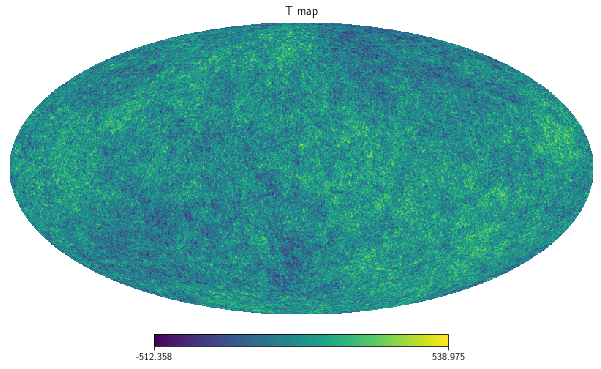

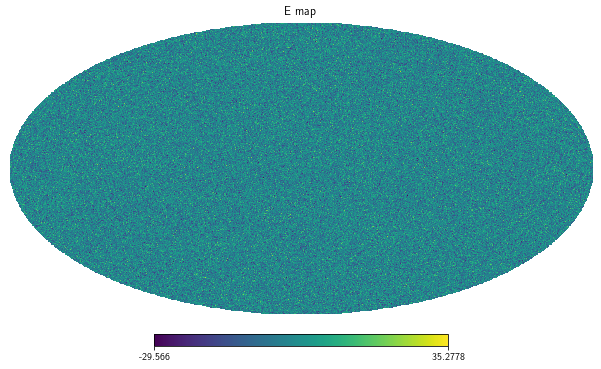

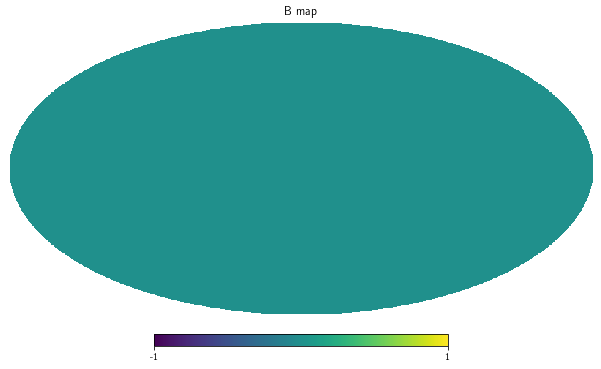

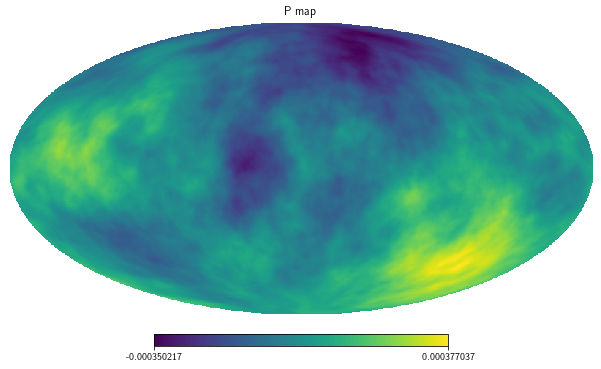

In [11]:
for k in ['t', 'e', 'b', 'p']:
    hp.mollview(hp.alm2map(alms[k], nside=1024), title=f'{k.upper()} map')

Let's check how the spectra of these map looks like, and if they follow the input spectra we used.

We estimate the pseudo Cl's by 
\begin{equation}
\hat C_\ell^{XY} = \frac{1}{2\ell+1}\sum_{m=-\ell}^{\ell} X_{\ell m} Y^*_{\ell m}
\end{equation}

Text(0, 0.5, '$ \\ell(\\ell+1)/ 2\\pi \\; C_\\ell $')

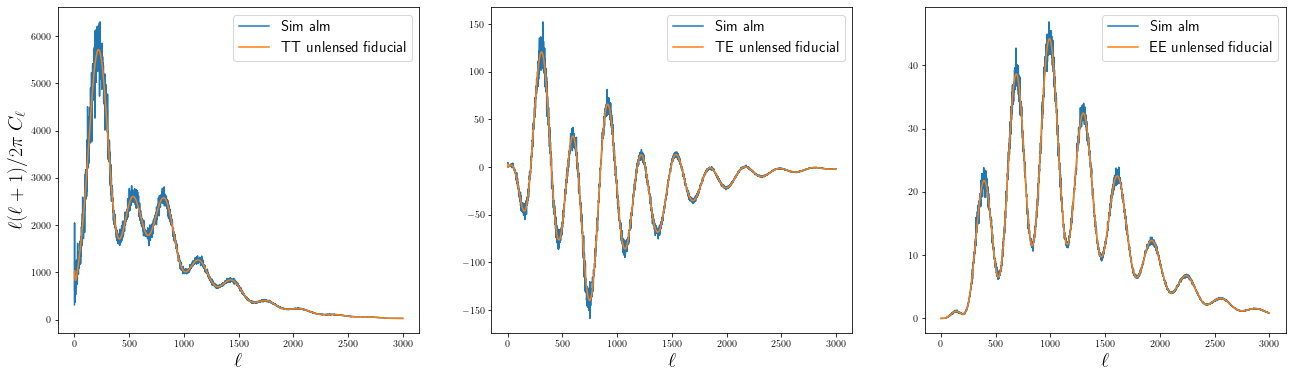

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(22, 6))

ell = np.arange(1, 3000)

for ax, (x, y) in zip(axs.flatten(), ['tt', 'te', 'ee']):
    ax.plot(ell, f(ell)*hp.alm2cl(alms[x], alms[y])[ell], label='Sim alm')
    ax.plot(ell, f(ell)*cl_unl[x+y][ell], label=f'{(x+y).upper()} unlensed fiducial')
    ax.set_xlabel(r'$\ell$')
    ax.legend()
axs[0].set_ylabel(r'$ \ell(\ell+1)/ 2\pi \; C_\ell $')
    # ax.set_xscale('log')

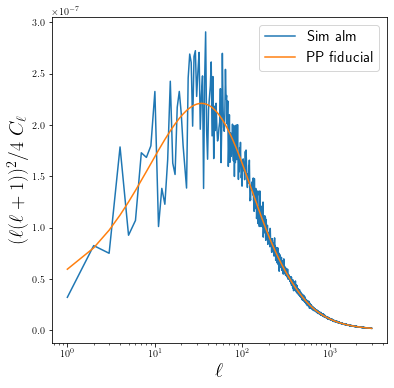

In [13]:

ell = np.arange(1, 3000)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(ell, pp2kk(ell)*hp.alm2cl(alms['p'])[ell], label='Sim alm')
ax.plot(ell, pp2kk(ell)*cl_unl['pp'][ell], label=f'PP fiducial')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$ (\ell(\ell+1))^2/ 4 \; C_\ell $')
ax.legend()
ax.set_xscale('log')

# fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# for ax, (x, y) in zip(axs.flatten(), ['pt', 'pe']):
#     ax.plot(ell, ell**3*hp.alm2cl(alms[x], alms[y])[ell], label='Sim alm')
#     ax.plot(ell, ell**3*cl_unl[x+y][ell], label=f'{(x+y).upper()} unlensed fiducial')
#     ax.set_xlabel(r'$\ell$')
#     ax.legend()
#     ax.set_xscale('log')
# axs[0].set_ylabel(r'$ \ell^3 \; C_\ell $')

# 3 - Lens the CMB maps

We will use the **lenspyx** package to lens the CMB maps we generated.

The lensing operation is defined by 

\begin{equation}
X^{len}(\boldsymbol{\hat n}) = X^{unl}(\boldsymbol{\hat n} + \boldsymbol{d}(\boldsymbol{\hat n}))
\end{equation}

Where $X\in[T, Q, U]$ and $\boldsymbol{d}$ is the deflection vector field.
We utsually decompose it into a potential $\phi$ and curl $\omega$ terms: $\boldsymbol{d} = \vec \nabla \phi + \vec\nabla \times (\omega \hat e_z)$. IN the Born approximation (ie. we only have one plane making the lensing), the curl term vanishes.
We will also use the convergence field $\kappa \equiv -\frac{1}{2} \Delta \phi$.


In practice, in **lenspyx**, the lensing operation defined above is applied as a remapping of the pixels of the CMB maps. This is done with an interpolation of the grid.


In [14]:
# parameters which impact of the accuracy of the result (and the execution time):

lmax_out = 2048  # desired lmax of the lensed field.
nside_lens = 2048 # The lensed tlm's are computed with healpy map2alm from a lensed map at resolution 'nside_lens'
facres = -1 # the deflected map is constructed by interpolation of the undeflected map,
           # built at target resolution ~ :math:`0.7 * 2^{-\rm facres}.` arcmin

We first transform the lensing potential field into a spin-1 deflection field. 

In [15]:
dlm = hp.almxfl(alms['p'], np.sqrt(np.arange(lmax_out + 1, dtype=float) * np.arange(1, lmax_out + 2)))

We now deflect the temperature map. Lenspyx deflect the temperature field at the map level, so the output is an healpix map with nside = nside_lens.
The result of the lensing operation is cached to avoid recomputing it the next time.


**Note:** We now focus on the temperature filed only, but as an exercise you can do the same on the polarisation fields, and reconstruct the lensing potential with the full T, E and B fields. You will see that the lensing creates B mode signal.

In [16]:
fn_tlens = 'tmap_len'

if not cacher.is_cached(fn_tlens):
    Tlen  = lenspyx.alm2lenmap(alms['t'], [dlm, None], nside_lens, facres=facres)
    cacher.cache(fn_tlens, Tlen)
Tlen = cacher.load(fn_tlens)

Let's compare the lensed map we generated with the unlensed one. 

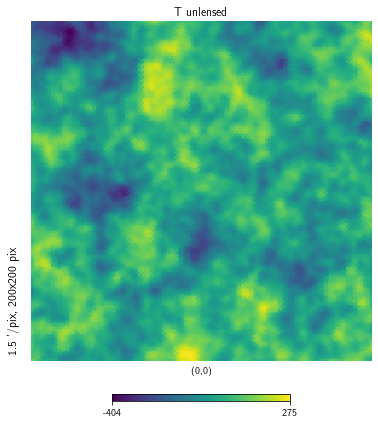

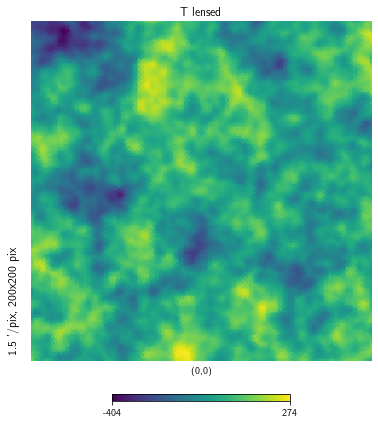

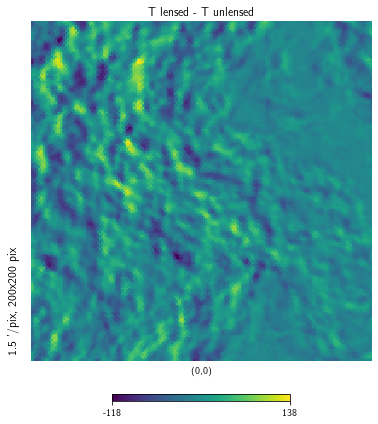

In [17]:
hp.gnomview(hp.alm2map(alms['t'], nside=nside_lens), title='T unlensed')
hp.gnomview(Tlen, title='T lensed')
hp.gnomview(Tlen- hp.alm2map(alms['t'], nside=nside_lens), title='T lensed - T unlensed')



We can compare the power spectrum of the lensed map with the fiducial lensed power spectrum

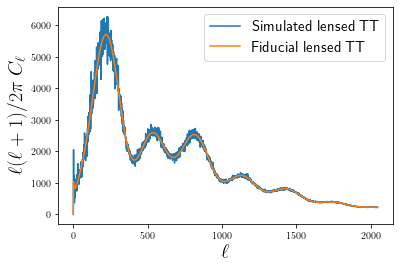

In [18]:
ell = np.arange(2048)

plt.plot(ell, f(ell)*hp.anafast(Tlen, lmax=ell[-1], iter=0), label='Simulated lensed TT')
plt.plot(ell, f(ell)*cl_len['tt'][ell], label='Fiducial lensed TT')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$ \ell(\ell+1)/ 2\pi \; C_\ell $')
plt.legend()


# 4- Beam and noise


We now simulate observed CMB maps by convolving the lensed maps with a gaussian beam (resolution of our instrument) and adding a white noise.

In [19]:
nlev_t = 5.  #Temperature noeise level in muK.arcmin
nlev_p = 5*np.sqrt(2.) #Polarisation noeise level in muK.arcmin (we wont use it here)

beam_fwhm_amin = 3. # Full width at half maximum of the gaussian beam of our instrument, in arcmin

lmax_ivf = 2048 
lmin_ivf = 10
# We will not the use the CMB modes outside of this interval
# IVF means inverse variance filter, this is an input of our quadratic estimator 


We generate the noise alm's with flat spectrum with variance given by nlev_t

In [20]:
noise_lm = hp.synalm(np.ones(lmax_ivf+1)*(nlev_t*np.pi /180/60)**2)

Check it's working 

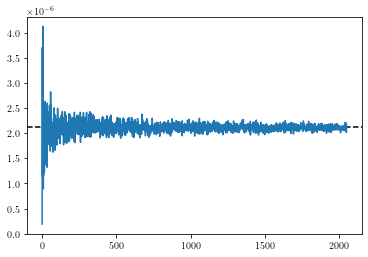

In [21]:
ell = np.arange(lmax_ivf+1)
plt.axhline(y=(nlev_t*np.pi /180/60)**2, c='k', ls='--')
plt.plot(ell, hp.alm2cl(noise_lm)[ell])

We now convolve the map with a beam and add the noise

In [22]:
cl_beam = hp.gauss_beam(fwhm=beam_fwhm_amin*np.pi/180/60, lmax=lmax_ivf)


In [23]:
tlm = hp.map2alm(Tlen, iter=3, lmax=lmax_ivf)
hp.almxfl(tlm, cl_beam, inplace=True)

tobs_lm = tlm + noise_lm
# This is our observed temperature map

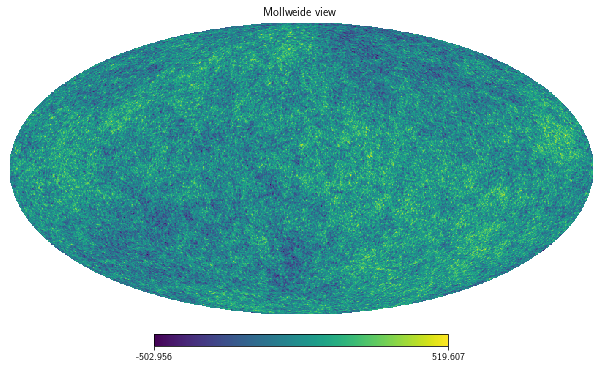

In [26]:
hp.mollview(hp.alm2map(tobs_lm, nside=1024))